In [1]:

import os
from os.path import join
import yaml
import pickle
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


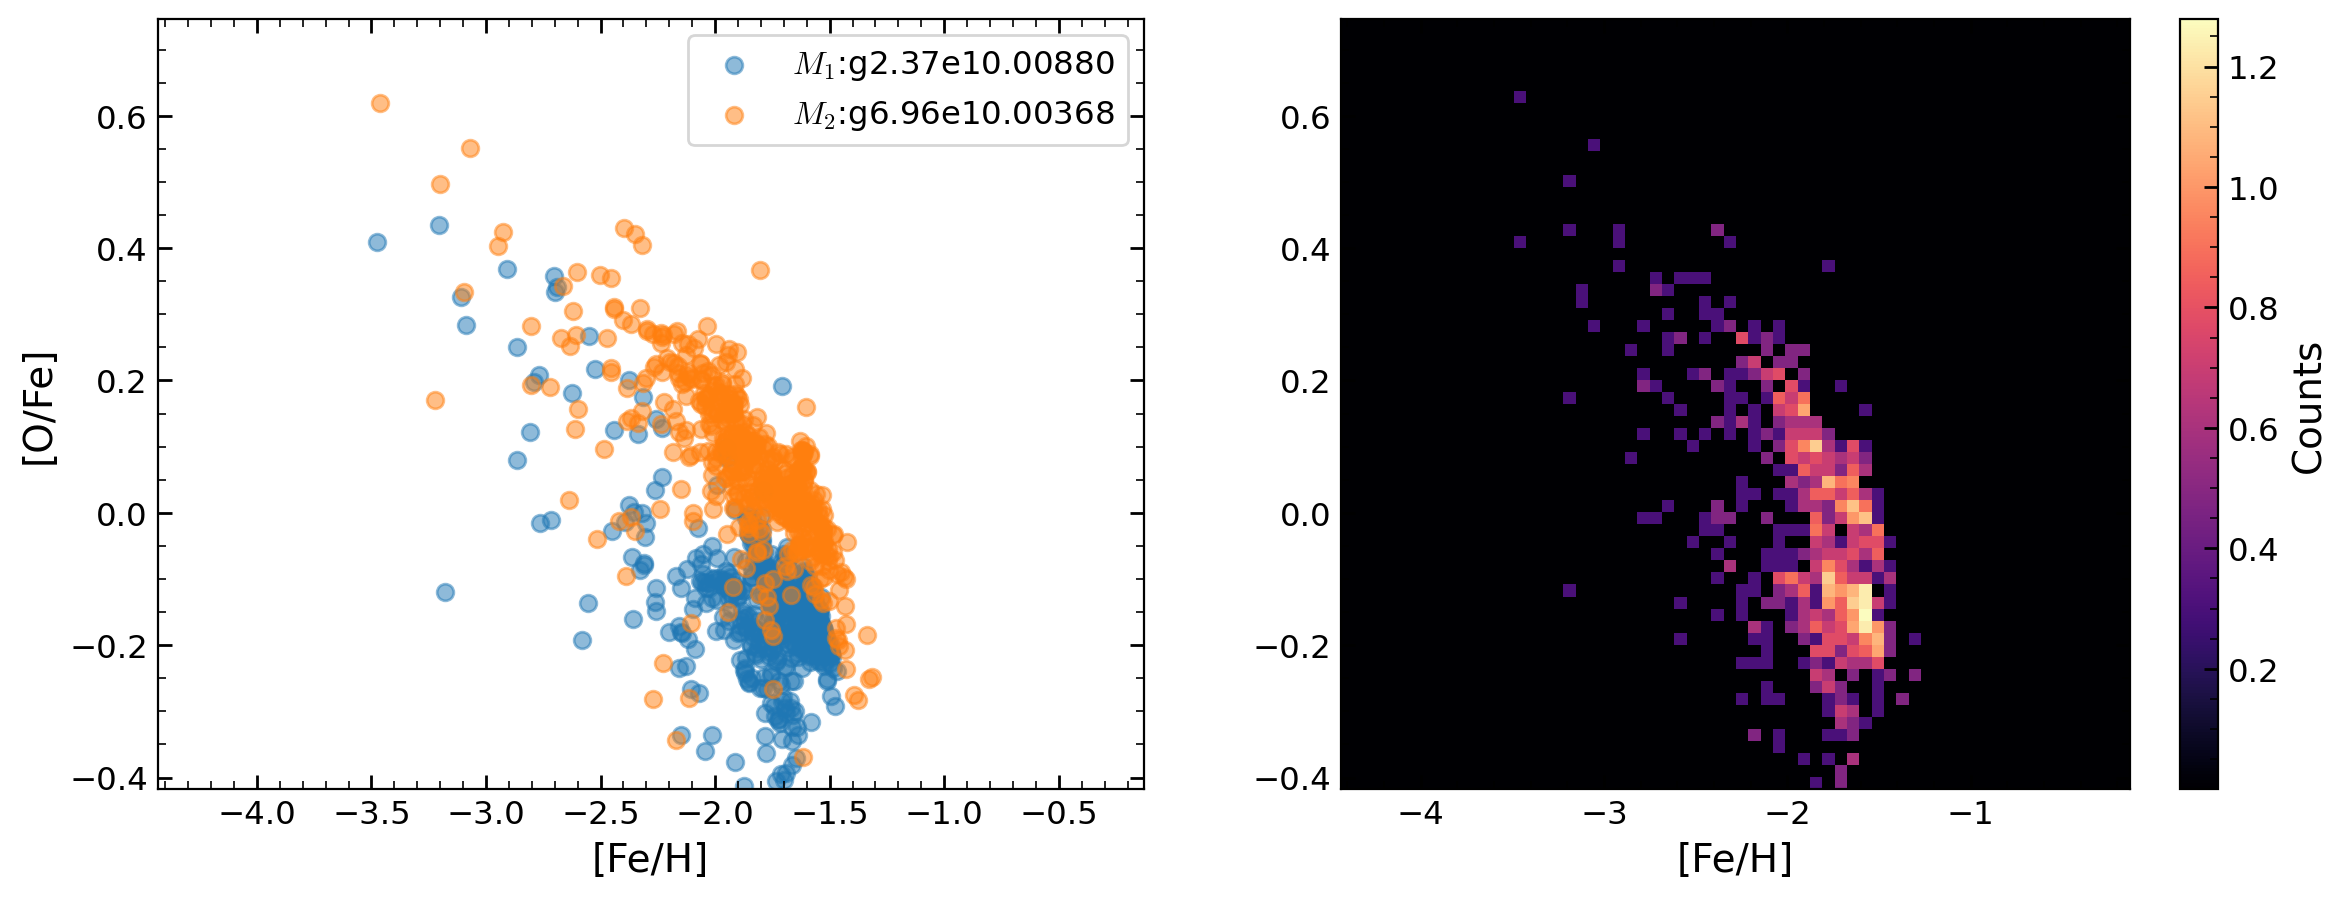

In [2]:
data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

data_to_plot_halos = pd.read_parquet('./halos_0.parquet')

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
for i, galaxy in enumerate(data_to_plot_halos['Galaxy_name'].unique()):
    observables =  data_to_plot_halos[data_to_plot_halos['Galaxy_name'] == galaxy]
    ax.scatter(observables['feh'], observables['ofe'], label=f'$M_{i+1}$:{galaxy}',alpha=0.5)
    ax.set_xlabel('[Fe/H]')   
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend()
ax = fig.add_subplot(122)
im = ax.imshow(np.load('x_0.npy').T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='magma')
ax.set_xlabel('[Fe/H]')   
# ax.set_ylabel('[O/Fe]')
cbar = fig.colorbar(im, ax=ax, label='Counts')
cbar.set_label('Counts', size=14)

fig.savefig('scatter_2subhalos.png')

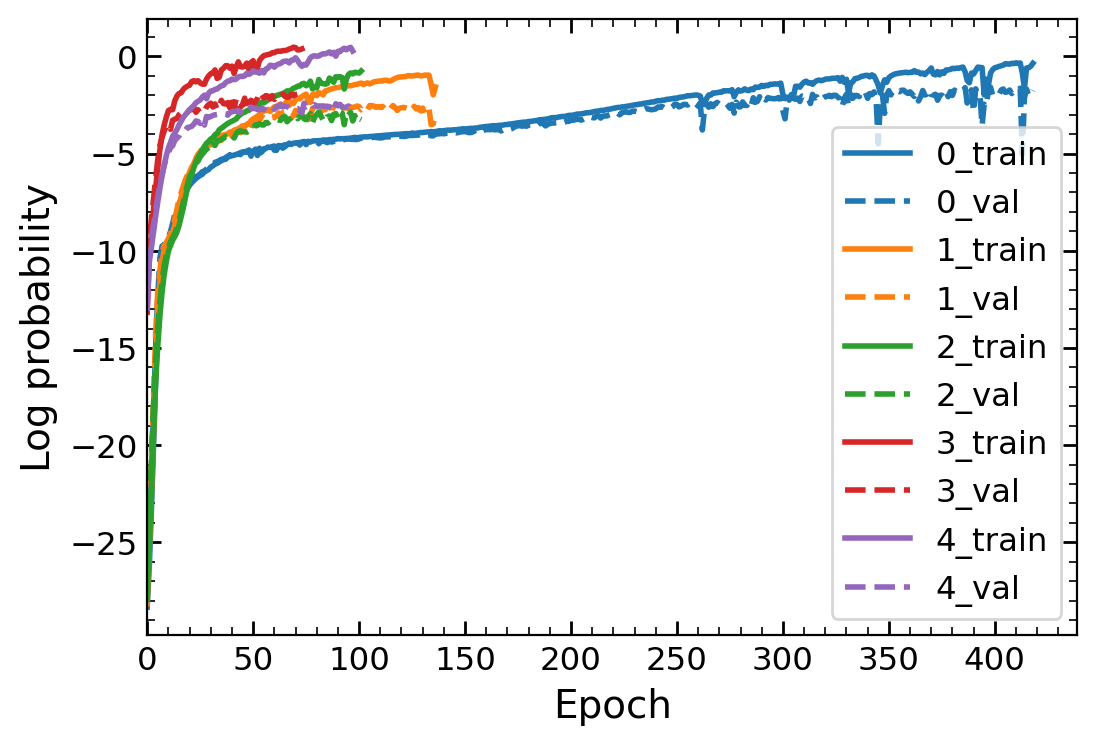

In [3]:
# Open the JSON file
with open('toy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [9]:
labels = [r'$\log_{10}(M_{s, 1})\ [M_\odot]$', r'$\log_{10}(M_{s, 2})\ [M_\odot]$', r'$\log_{10}(M_{DM, 1})\ [M_\odot]$', r'$\log_{10}(M_{DM, 2})\ [M_\odot]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$']

samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterior_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 1739 posterior samples:   0%|          | 0/1739 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 1371 posterior samples:   0%|          | 0/1371 [00:00<?, ?it/s]

Drawing 796 posterior samples:   0%|          | 0/796 [00:00<?, ?it/s]

Drawing 3449 posterior samples:   0%|          | 0/3449 [00:00<?, ?it/s]

Drawing 1371 posterior samples:   0%|          | 0/1371 [00:00<?, ?it/s]

Drawing 992 posterior samples:   0%|          | 0/992 [00:00<?, ?it/s]

Drawing 2692 posterior samples:   0%|          | 0/2692 [00:00<?, ?it/s]

Drawing 1496 posterior samples:   0%|          | 0/1496 [00:00<?, ?it/s]

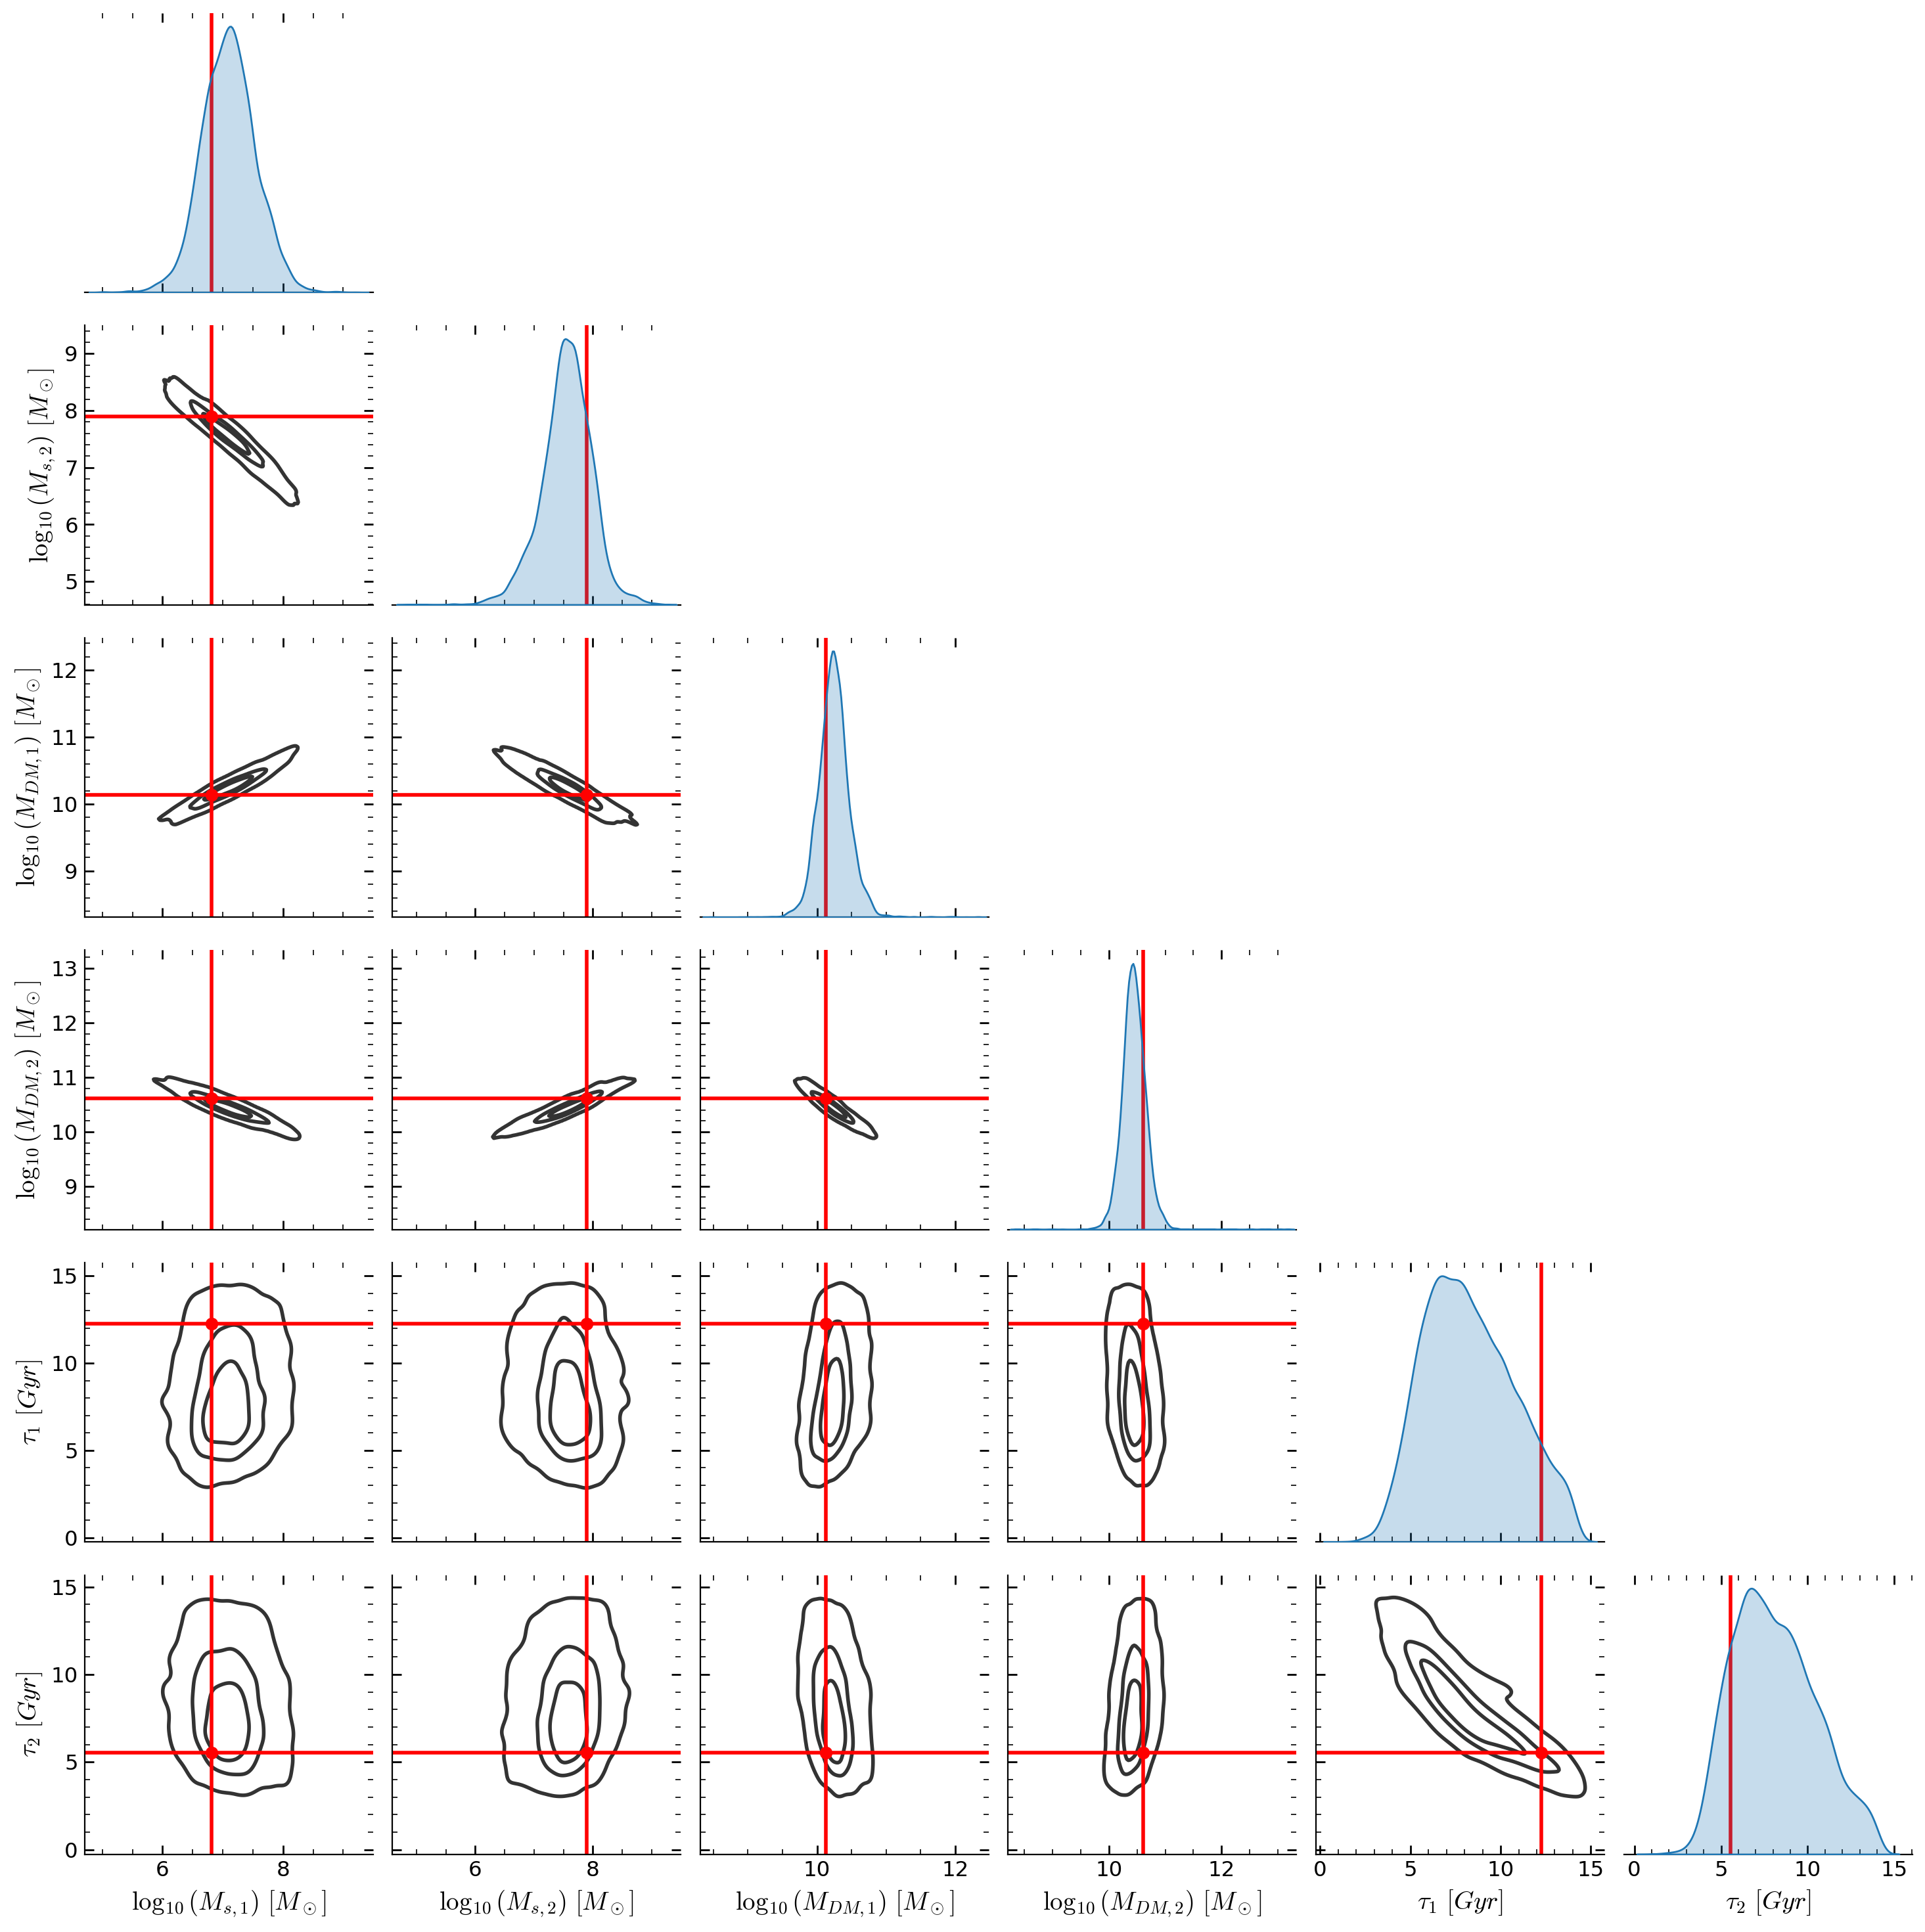

In [5]:
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels = labels,
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)

fig.savefig('corner_2subhalos.png')

In [6]:
metric = PosteriorCoverage(num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=torch.from_numpy(np.load('./x_test.npy')), theta=torch.from_numpy(np.load('./theta_test.npy'))
)

fig[3].savefig('coverage_2subhalos.png')

  0%|          | 0/999 [00:00<?, ?it/s]

  5%|▌         | 52/999 [00:57<17:25,  1.10s/it]WARNING:root:Only 0.000% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1389 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  5%|▌         | 52/999 [02:00<36:25,  2.31s/it]


KeyboardInterrupt: 

In [20]:
theta_test.shape

torch.Size([9, 6])

In [25]:
from sbibm.metrics.c2st import c2st

theta_test = torch.from_numpy(np.load('./theta_test.npy')).to('cuda')
x_test = torch.from_numpy(np.load('./x_test.npy')).to('cuda')
posterior_samples = torch.zeros_like(theta_test)
for i, x_0 in enumerate(x_test):
    posterior_samples[i] = samples['NPE'].sample((10_000,), x=x_0).mean(axis=0)


Drawing 3455 posterior samples:   0%|          | 0/3455 [00:00<?, ?it/s]

Drawing 1350 posterior samples:   0%|          | 0/1350 [00:00<?, ?it/s]

Drawing 1017 posterior samples:   0%|          | 0/1017 [00:00<?, ?it/s]

Drawing 2669 posterior samples:   0%|          | 0/2669 [00:00<?, ?it/s]

Drawing 1509 posterior samples:   0%|          | 0/1509 [00:00<?, ?it/s]

Drawing 3538 posterior samples:   0%|          | 0/3538 [00:00<?, ?it/s]

Drawing 1286 posterior samples:   0%|          | 0/1286 [00:00<?, ?it/s]

Drawing 1029 posterior samples:   0%|          | 0/1029 [00:00<?, ?it/s]

Drawing 2601 posterior samples:   0%|          | 0/2601 [00:00<?, ?it/s]

Drawing 1546 posterior samples:   0%|          | 0/1546 [00:00<?, ?it/s]

Drawing 3466 posterior samples:   0%|          | 0/3466 [00:00<?, ?it/s]

Drawing 1323 posterior samples:   0%|          | 0/1323 [00:00<?, ?it/s]

Drawing 952 posterior samples:   0%|          | 0/952 [00:00<?, ?it/s]

Drawing 2767 posterior samples:   0%|          | 0/2767 [00:00<?, ?it/s]

Drawing 1492 posterior samples:   0%|          | 0/1492 [00:00<?, ?it/s]

Drawing 3448 posterior samples:   0%|          | 0/3448 [00:00<?, ?it/s]

Drawing 1366 posterior samples:   0%|          | 0/1366 [00:00<?, ?it/s]

Drawing 929 posterior samples:   0%|          | 0/929 [00:00<?, ?it/s]

Drawing 2661 posterior samples:   0%|          | 0/2661 [00:00<?, ?it/s]

Drawing 1596 posterior samples:   0%|          | 0/1596 [00:00<?, ?it/s]

Drawing 3494 posterior samples:   0%|          | 0/3494 [00:00<?, ?it/s]

Drawing 1305 posterior samples:   0%|          | 0/1305 [00:00<?, ?it/s]

Drawing 997 posterior samples:   0%|          | 0/997 [00:00<?, ?it/s]

Drawing 2652 posterior samples:   0%|          | 0/2652 [00:00<?, ?it/s]

Drawing 1552 posterior samples:   0%|          | 0/1552 [00:00<?, ?it/s]

Drawing 3470 posterior samples:   0%|          | 0/3470 [00:00<?, ?it/s]

Drawing 1361 posterior samples:   0%|          | 0/1361 [00:00<?, ?it/s]

Drawing 996 posterior samples:   0%|          | 0/996 [00:00<?, ?it/s]

Drawing 2694 posterior samples:   0%|          | 0/2694 [00:00<?, ?it/s]

Drawing 1479 posterior samples:   0%|          | 0/1479 [00:00<?, ?it/s]

Drawing 3381 posterior samples:   0%|          | 0/3381 [00:00<?, ?it/s]

Drawing 1329 posterior samples:   0%|          | 0/1329 [00:00<?, ?it/s]

Drawing 1027 posterior samples:   0%|          | 0/1027 [00:00<?, ?it/s]

Drawing 2715 posterior samples:   0%|          | 0/2715 [00:00<?, ?it/s]

Drawing 1548 posterior samples:   0%|          | 0/1548 [00:00<?, ?it/s]

Drawing 3430 posterior samples:   0%|          | 0/3430 [00:00<?, ?it/s]

Drawing 1330 posterior samples:   0%|          | 0/1330 [00:00<?, ?it/s]

Drawing 1002 posterior samples:   0%|          | 0/1002 [00:00<?, ?it/s]

Drawing 2719 posterior samples:   0%|          | 0/2719 [00:00<?, ?it/s]

Drawing 1519 posterior samples:   0%|          | 0/1519 [00:00<?, ?it/s]

Drawing 3474 posterior samples:   0%|          | 0/3474 [00:00<?, ?it/s]

Drawing 1367 posterior samples:   0%|          | 0/1367 [00:00<?, ?it/s]

Drawing 927 posterior samples:   0%|          | 0/927 [00:00<?, ?it/s]

Drawing 2685 posterior samples:   0%|          | 0/2685 [00:00<?, ?it/s]

Drawing 1547 posterior samples:   0%|          | 0/1547 [00:00<?, ?it/s]

In [30]:
from sbibm.metrics.c2st import c2st
from sbibm.metrics.mmd import mmd

c2st_score = c2st(theta_test[:3], posterior_samples[:3])
mmd_score = mmd(theta_test[:5], posterior_samples[:5])
print('c2st score:', c2st_score)
print('mmd^2 score:', mmd_score**2)

c2st score: tensor([0.])
mmd^2 score: tensor(0.0006, device='cuda:0', dtype=torch.float64)
